In [2]:
# 라이브러리 설정
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random

# 랜덤 시드 고정
SEED=12
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# 구글 드라이브 폴더 마운트

from google.colab import drive, files
drive.mount('/gdrive')

Mounted at /gdrive


In [8]:
drive_path='/gdrive/My Drive/'
smp=pd.read_csv(drive_path+'Colab Notebooks/smp/smp.csv')


In [9]:
# 날짜 데이터를 time series 형식으로 변환
smp['date']=pd.to_datetime(smp['date'])
smp['day_of_week']=smp['date'].dt.dayofweek

print(smp.shape)
smp.head(10)

(820, 5)


,date,smp_max,smp_min,smp_mean,day_of_week
0,2018-01-01,95.93,73.69,84.88,0
1,2018-01-02,95.70,88.36,92.57,1
2,2018-01-03,96.47,88.37,92.34,2
3,2018-01-04,98.09,88.37,92.14,3
4,2018-01-05,96.12,88.23,92.42,4
5,2018-01-06,94.09,88.38,91.14,5
6,2018-01-07,93.31,85.28,88.42,6
7,2018-01-08,95.69,87.72,92.71,0
8,2018-01-09,95.71,88.48,92.61,1
9,2018-01-10,98.09,88.48,92.90,2


In [10]:
smp['day_of_week']=smp['day_of_week'].astype('category')
smp=pd.get_dummies(smp,columns=['day_of_week'],prefix='W',drop_first=True)

smp.head()

,date,smp_max,smp_min,smp_mean,W_1,W_2,W_3,W_4,W_5,W_6
0,2018-01-01,95.93,73.69,84.88,0,0,0,0,0,0
1,2018-01-02,95.70,88.36,92.57,1,0,0,0,0,0
2,2018-01-03,96.47,88.37,92.34,0,1,0,0,0,0
3,2018-01-04,98.09,88.37,92.14,0,0,1,0,0,0
4,2018-01-05,96.12,88.23,92.42,0,0,0,1,0,0


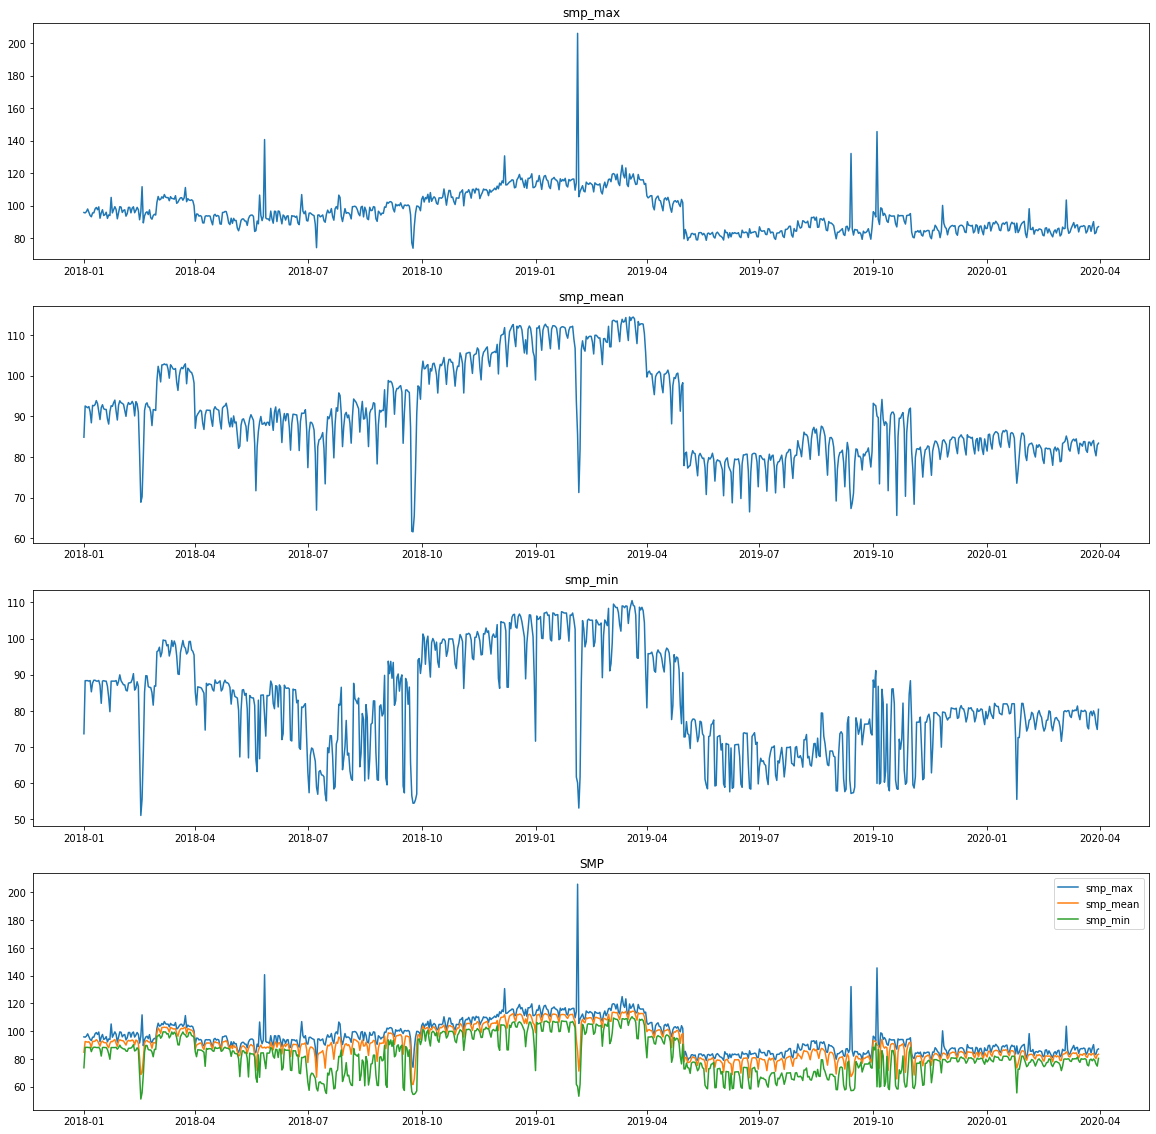

In [11]:
# 그래프 그리기

fig,axes=plt.subplots(4,1,figsize=(20,20))
axes[0].plot(smp['date'],smp['smp_max'])
axes[0].set_title('smp_max')
axes[1].plot(smp['date'],smp['smp_mean'])
axes[1].set_title('smp_mean')
axes[2].plot(smp['date'],smp['smp_min'])
axes[2].set_title('smp_min')

axes[3].plot(smp['date'],smp['smp_max'],label='smp_max')
axes[3].plot(smp['date'],smp['smp_mean'],label='smp_mean')
axes[3].plot(smp['date'],smp['smp_min'],label='smp_min')
axes[3].set_title('SMP')
axes[3].legend()

plt.show()

# 데이터 전처리

In [12]:
# Setting 
train_split_idx=729 # 2020.1.1. 행 인덱스 번호
window_size=10      # 과거 10일 동안 시계열 데이터를 학습 데이터로 사용
future=3            # 3일 후의 타깃 예측

# Features
x_train=smp.iloc[:train_split_idx-window_size-future,0:]

# Targets
y_train=smp.iloc[window_size+future:train_split_idx,[3]] # 'smp_mean'열

print(x_train.shape,y_train.shape)

(716, 10) (716, 1)


In [13]:
x_train.head(15)

,date,smp_max,smp_min,smp_mean,W_1,W_2,W_3,W_4,W_5,W_6
0,2018-01-01,95.93,73.69,84.88,0,0,0,0,0,0
1,2018-01-02,95.70,88.36,92.57,1,0,0,0,0,0
2,2018-01-03,96.47,88.37,92.34,0,1,0,0,0,0
3,2018-01-04,98.09,88.37,92.14,0,0,1,0,0,0
4,2018-01-05,96.12,88.23,92.42,0,0,0,1,0,0
5,2018-01-06,94.09,88.38,91.14,0,0,0,0,1,0
6,2018-01-07,93.31,85.28,88.42,0,0,0,0,0,1
7,2018-01-08,95.69,87.72,92.71,0,0,0,0,0,0
8,2018-01-09,95.71,88.48,92.61,1,0,0,0,0,0
9,2018-01-10,98.09,88.48,92.90,0,1,0,0,0,0


In [15]:
y_train.head(5)

,smp_mean
13,89.23
14,92.17
15,92.88
16,91.88
17,91.72


In [16]:
# x_test

test_start=train_split_idx-window_size-future
test_end=smp.shape[0]-window_size-future
x_test=smp.iloc[test_start:test_end,0:]

# y_test
# label_start = + future # 테스트 데이터의 첫 번째 타깃 데이터 위치
y_test=smp.iloc[train_split_idx:,[3]] # 'smp_mean' 열 선택

print(x_test.shape,y_test.shape)

(91, 10) (91, 1)


In [17]:
x_test.head(15)

,date,smp_max,smp_min,smp_mean,W_1,W_2,W_3,W_4,W_5,W_6
716,2019-12-19,87.62,80.90,84.64,0,0,1,0,0,0
717,2019-12-20,88.08,80.12,84.86,0,0,0,1,0,0
718,2019-12-21,83.45,79.85,82.37,0,0,0,0,1,0
719,2019-12-22,84.47,76.97,80.76,0,0,0,0,0,1
720,2019-12-23,88.43,78.22,84.16,0,0,0,0,0,0
721,2019-12-24,87.89,80.61,84.56,1,0,0,0,0,0
722,2019-12-25,83.20,79.87,81.53,0,1,0,0,0,0
723,2019-12-26,87.34,80.03,84.70,0,0,1,0,0,0
724,2019-12-27,87.69,80.56,84.66,0,0,0,1,0,0
725,2019-12-28,84.58,80.38,81.98,0,0,0,0,1,0


In [18]:
y_test.head(5)

,smp_mean
729,81.46
730,85.51
731,85.63
732,83.26
733,81.95


* 딥러닝 모델의 성능을 확보하려면 피처 스케일링으로 전처리를 하는 것이 좋다.
* 입력 데이터를 0~1 범위로 정규화

In [22]:
# Feature Scaling

x_train_scaled=x_train.loc[:,'smp_max':]
x_test_scaled=x_test.loc[:,'smp_max':]


In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(x_train_scaled.values)
x_train_scaled.loc[:,:]=scaler.transform(x_train_scaled.values)
x_test_scaled.loc[:,:]=scaler.transform(x_test_scaled.values)

In [24]:
# Mini Batch 크기로 시계열 변환

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
train_data=timeseries_dataset_from_array(
    x_train_scaled,y_train,sequence_length=window_size,batch_size=16)

test_data=timeseries_dataset_from_array(
    x_test_scaled,y_test,sequence_length=window_size,batch_size=16
)

print(train_data)
print(test_data)

<BatchDataset shapes: ((None, None, 9), (None, 1)), types: (tf.float64, tf.float64)>
<BatchDataset shapes: ((None, None, 9), (None, 1)), types: (tf.float64, tf.float64)>


미니 배치의 형태 확인,

In [26]:
for batch in test_data.take(1):
  inputs,targets=batch

print("Input",inputs.numpy().shape)
print("Target",targets.numpy().shape)


Input (16, 10, 9)
Target (16, 1)


In [27]:
inputs[0] # 16개 데이터를 묶은 배치를 구성하는 데이터 중에서 첫 번째 데이터를 출력

<tf.Tensor: shape=(10, 9), dtype=float64, numpy=
array([[0.10309278, 0.50160013, 0.43581017, 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        ],
       [0.10657975, 0.48846219, 0.43996975, 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        ],
       [0.07148272, 0.48391443, 0.39289091, 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        ],
       [0.07921468, 0.43540509, 0.36245037, 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        ],
       [0.10923287, 0.45645949, 0.42673473, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.10513948, 0.49671551, 0.4342976 , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.06958763, 0.48425131, 0.37700889, 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.10097029, 0.48694627, 0.4369446 , 0.        , 0.        ,
        

* 정규화 변환을 했기 때문에, 각 피처의 데이터는 0~1 범위의 값을 갖는다

In [28]:
targets[0]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([81.46])>

# LSTM 모델로 시계열 예측

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,LSTM,Dense

model=Sequential()
model.add(Input(shape=[10,9]))

model.add(LSTM(units=32,return_sequences=False))
model.add(Dense(units=1,activation='linear'))

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5376      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________


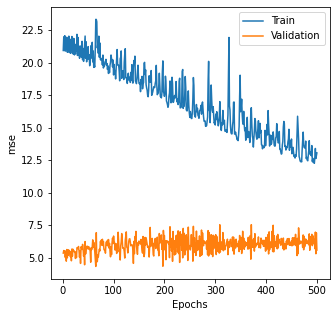

In [32]:
# 모델 훈련 

history=model.fit(train_data,epochs=500,
                  validation_data=test_data,
                  verbose=0)


# 손실 함수 그래프
def plot_loss_curve(history,total_epoch=10,start=1):
  plt.figure(figsize=(5,5))
  plt.plot(range(start,total_epoch+1),
           history.history['loss'][start-1:total_epoch],
           label='Train')
  
  plt.plot(range(start,total_epoch+1),
           history.history['val_loss'][start-1:total_epoch],
           label='Validation')
  
  plt.xlabel('Epochs')
  plt.ylabel('mse')
  plt.legend()
  plt.show()

plot_loss_curve(history=history,total_epoch=len(history.history['loss']),start=1)

In [33]:
y_pred=model.predict(test_data)
y_pred.shape

(82, 1)

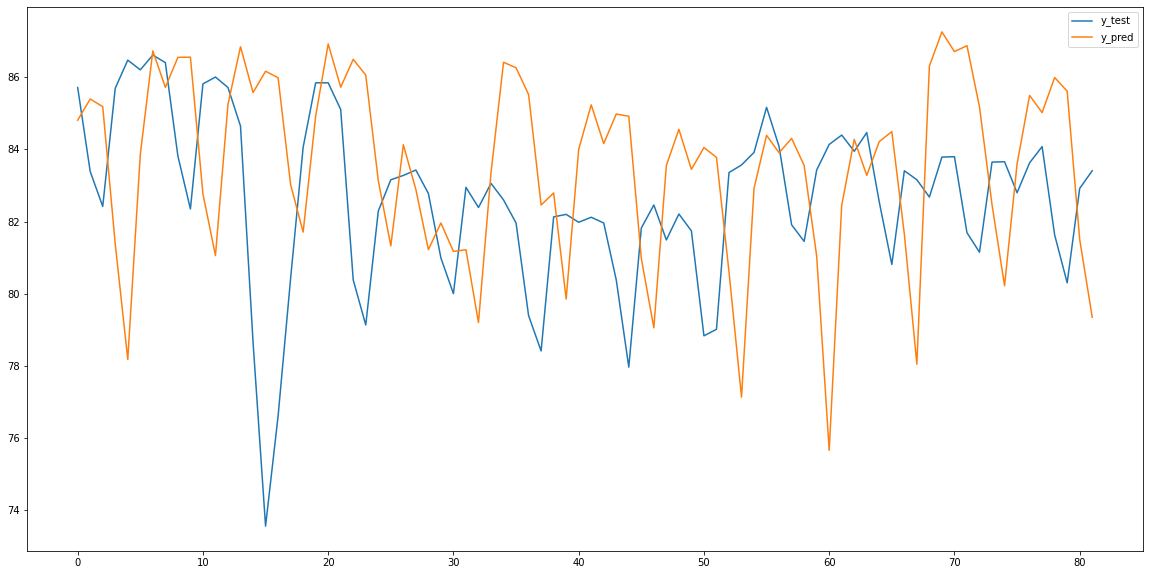

In [34]:
plt.figure(figsize=(20,10))
plt.plot(range(len(y_pred)),y_test[window_size-1:],label='y_test')
plt.plot(range(len(y_pred)),y_pred,label='y_pred')
plt.legend()
plt.show()